## Train previous model using false positive samples for better accuracy

In [1]:
INPUT_DIR = '../../input/kaggle-sea-lion/'
OUTPUT_DIR = '../../output/kaggle-sea-lion/15/'

IMAGE_DIMS = (42,42,3)
LABEL_DIMS = (6,)
INPUT_DATASET_NAME = 'lion-patches-0px'
INPUT_DATASET_NAME_FALSE_POSITIVES = 'lion-patches-false-positives'
LOAD_WEIGHTS_FILE = INPUT_DIR + '05/weights-medium1-42x42-0.94.h5'
LOAD_WEIGHTS_FILE = None
LOAD_MODEL_FILE = None
SAVE_WEIGHTS_FILE = OUTPUT_DIR + 'last-weights-medium1-42x42.h5'
SAVE_MODEL_FILE = None

RUN_TRAINING = True

Y_CHANGE = None
Y_CHANGE = ((1,5),(2,5),(3,5),(4,5))
RECREATE_OUTPUT_DIR = True
TRAIN_WEIGHT = (1,1,1,1,1,1)
TEST_WEIGHT = (1,1,1,1,1,1)
TRAIN_EPOCHS = 10
INPUT_RANGE = 1

BATCH_SIZE=48

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import os
import glob
import cv2

from keras.preprocessing.image import ImageDataGenerator
from keras import models

from modules.logging import logger
import modules.utils as utils
from modules.utils import Timer
import modules.logging
import modules.cnn as cnn
import modules.lions as lions
import modules.objectdetect as objectdetect

Using TensorFlow backend.


### Prepare output dir

In [3]:
utils.mkdirs(OUTPUT_DIR, dirs=['tf-logs','weights'], recreate=RECREATE_OUTPUT_DIR)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
TF_LOGS_DIR = OUTPUT_DIR + 'tf-logs/'
WEIGHTS_DIR = OUTPUT_DIR + 'weights/'
input_dataset_path = INPUT_DIR + '02/' + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
input_dataset_path_false_positives = INPUT_DIR + '10/' + utils.dataset_name(INPUT_DATASET_NAME_FALSE_POSITIVES, IMAGE_DIMS)
logger.info('Dir ' + OUTPUT_DIR + ' created')

2017-06-03 18:46:35,796 INFO Dir ../../output/kaggle-sea-lion/15/ created


### Prepare train, validate and test data flows

In [4]:
logger.info('Using dataset ' + input_dataset_path + ' as input')
h5file = h5py.File(input_dataset_path, 'r')
h5file_false_positives = h5py.File(input_dataset_path_false_positives, 'r')

#used for image augmentation (creating new images for balancing)
image_augmentation_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=359,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        horizontal_flip=True,
        vertical_flip=True)

#applied to all images during training
image_randomize_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=359,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        horizontal_flip=True,
        vertical_flip=True)

logger.info('preparing train data')
#false positives samples
train_batch_generator1 = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
train_batch_generator2 = utils.BatchGeneratorXYH5(h5file_false_positives, start_ratio=0, end_ratio=INPUT_RANGE)
# train_batch_generator = utils.JoinGeneratorsXY([train_batch_generator1,train_batch_generator2])
train_balance_generator = utils.ClassBalancerGeneratorXY(train_batch_generator2,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=TRAIN_WEIGHT,
                                                         max_augmentation_ratio=0,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0, end_ratio=0.7,
                                                         change_y=Y_CHANGE)
train_generator = utils.image_augmentation_xy(train_balance_generator.flow(), image_randomize_generator)
logger.info('train size=' + str(train_balance_generator.size) + ' batches=' + str(train_balance_generator.nr_batches))


logger.info('preparing valid data')
valid_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
valid_balance_generator = utils.ClassBalancerGeneratorXY(valid_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=TEST_WEIGHT,
                                                         max_augmentation_ratio=0,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0.7, end_ratio=0.85,
                                                         change_y=Y_CHANGE)
logger.info('valid size=' + str(valid_balance_generator.size) + ' batches=' + str(valid_balance_generator.nr_batches))



logger.info('preparing test data')
test_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
test_balance_generator = utils.ClassBalancerGeneratorXY(test_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=TEST_WEIGHT,
                                                         max_augmentation_ratio=0,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0.85, end_ratio=1,
                                                         change_y=Y_CHANGE)
logger.info('test size=' + str(test_balance_generator.size) + ' batches=' + str(test_balance_generator.nr_batches))

#FIXME when using 1 on end ratio size and nr_batches gets negative (h5 batch generator, not balancer...)

2017-06-03 18:46:35,834 INFO Using dataset ../../input/kaggle-sea-lion/02/lion-patches-0px-42-42.h5 as input
2017-06-03 18:46:35,843 INFO preparing train data
2017-06-03 18:46:35,845 INFO loading input data for class distribution analysis...
2017-06-03 18:46:35,847 INFO loading Y from raw dataset
2017-06-03 18:46:35,849 INFO > [started] generator dump...


33/33

2017-06-03 18:46:35,860 INFO > [done]    generator dump (10.545 ms)
2017-06-03 18:46:35,862 INFO raw sample class distribution
2017-06-03 18:46:35,864 INFO 0: 0
2017-06-03 18:46:35,866 INFO 1: 0
2017-06-03 18:46:35,867 INFO 2: 0
2017-06-03 18:46:35,869 INFO 3: 0
2017-06-03 18:46:35,870 INFO 4: 0
2017-06-03 18:46:35,872 INFO 5: 33
2017-06-03 18:46:35,874 INFO overall output samples per class: 33
2017-06-03 18:46:35,875 INFO augmentation/undersampling ratio per class
2017-06-03 18:46:35,876 INFO SETUP FLOW 0 0.7
2017-06-03 18:46:35,878 INFO calculating source range according to start/end range of the desired output..
2017-06-03 18:46:35,879 INFO output distribution for this flow
2017-06-03 18:46:35,881 INFO 0: 0 (0.00)
2017-06-03 18:46:35,882 INFO 1: 0 (0.00)
2017-06-03 18:46:35,884 INFO 2: 0 (0.00)
2017-06-03 18:46:35,885 INFO 3: 0 (0.00)
2017-06-03 18:46:35,886 INFO 4: 0 (0.00)
2017-06-03 18:46:35,888 INFO 5: 23 (1.00)
2017-06-03 18:46:35,889 INFO source range: 0-22 (22)
2017-06-03 18:

4065/4065

2017-06-03 18:46:36,231 INFO > [done]    generator dump (333.068 ms)
2017-06-03 18:46:36,235 INFO raw sample class distribution
2017-06-03 18:46:36,236 INFO 0: 2222
2017-06-03 18:46:36,238 INFO 1: 0
2017-06-03 18:46:36,239 INFO 2: 0
2017-06-03 18:46:36,240 INFO 3: 0
2017-06-03 18:46:36,242 INFO 4: 0
2017-06-03 18:46:36,244 INFO 5: 1843
2017-06-03 18:46:36,245 INFO overall output samples per class: 1843
2017-06-03 18:46:36,246 INFO augmentation/undersampling ratio per class
2017-06-03 18:46:36,248 INFO SETUP FLOW 0.7 0.85
2017-06-03 18:46:36,249 INFO calculating source range according to start/end range of the desired output..
2017-06-03 18:46:36,250 INFO output distribution for this flow
2017-06-03 18:46:36,252 INFO 0: 276 (0.83)
2017-06-03 18:46:36,253 INFO 1: 0 (0.00)
2017-06-03 18:46:36,254 INFO 2: 0 (0.00)
2017-06-03 18:46:36,256 INFO 3: 0 (0.00)
2017-06-03 18:46:36,257 INFO 4: 0 (0.00)
2017-06-03 18:46:36,258 INFO 5: 276 (1.00)
2017-06-03 18:46:36,262 INFO source range: 2887-3468 

4065/4065

2017-06-03 18:46:36,538 INFO > [done]    generator dump (267.238 ms)
2017-06-03 18:46:36,542 INFO raw sample class distribution
2017-06-03 18:46:36,543 INFO 0: 2222
2017-06-03 18:46:36,545 INFO 1: 0
2017-06-03 18:46:36,546 INFO 2: 0
2017-06-03 18:46:36,547 INFO 3: 0
2017-06-03 18:46:36,548 INFO 4: 0
2017-06-03 18:46:36,549 INFO 5: 1843
2017-06-03 18:46:36,551 INFO overall output samples per class: 1843
2017-06-03 18:46:36,552 INFO augmentation/undersampling ratio per class
2017-06-03 18:46:36,554 INFO SETUP FLOW 0.85 1
2017-06-03 18:46:36,555 INFO calculating source range according to start/end range of the desired output..
2017-06-03 18:46:36,556 INFO output distribution for this flow
2017-06-03 18:46:36,557 INFO 0: 276 (0.83)
2017-06-03 18:46:36,559 INFO 1: 0 (0.00)
2017-06-03 18:46:36,560 INFO 2: 0 (0.00)
2017-06-03 18:46:36,561 INFO 3: 0 (0.00)
2017-06-03 18:46:36,563 INFO 4: 0 (0.00)
2017-06-03 18:46:36,564 INFO 5: 276 (1.00)
2017-06-03 18:46:36,567 INFO source range: 3444-4032 (5

### Prepare CNN model

In [5]:
logger.info('Load CNN model')
#model = lions.convnet_alexnet2_lion_keras(IMAGE_DIMS)

model = None
if(LOAD_MODEL_FILE!=None and os.path.isfile(LOAD_MODEL_FILE)):
    with open(LOAD_MODEL_FILE, 'r') as model_file:
        my = model_file.read()
        model = models.model_from_yaml(my)
        logger.info('loaded model from file ' + LOAD_MODEL_FILE)
else:
    model = lions.convnet_medium1_lion_keras(IMAGE_DIMS)
    logger.info('loaded model from function convnet_medium1_lion_keras')
    

if(LOAD_WEIGHTS_FILE!=None and os.path.isfile(LOAD_WEIGHTS_FILE)):
    model.load_weights(LOAD_WEIGHTS_FILE)
    logger.info('Loaded model weights from ' + LOAD_WEIGHTS_FILE)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])    
logger.info('Model prepared')

2017-06-03 18:46:36,583 INFO Load CNN model
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:69: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_uniform", activation="relu")`
  model.add(convolutional.Conv2D(64, (3, 3), activation='relu', padding='same', init='glorot_uniform'))
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:71: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_uniform", activation="relu")`
  model.add(convolutional.Conv2D(128, (3, 3), activation='relu', padding='same', init='glorot_uniform'))
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:73: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_uniform", activation="relu")`
  model.add(convolutional.Conv2D(256, (3, 3), activation='relu', padding='same', i

## Train model

In [6]:
if(RUN_TRAINING):
    logger.info('Starting CNN training...')
    history = model.fit_generator(train_generator,
                  steps_per_epoch = train_balance_generator.nr_batches,
                  nb_epoch = TRAIN_EPOCHS,
                  callbacks = cnn.get_callbacks_keras(model, WEIGHTS_DIR, TF_LOGS_DIR),
                  validation_data = valid_balance_generator.flow(), 
                  validation_steps = valid_balance_generator.nr_batches,
                  verbose = 1)

    if(SAVE_MODEL_FILE!=None):
        with open(SAVE_MODEL_FILE, 'w') as model_file:
            model_file.write(model.to_yaml())
            logger.info('Saved last model to ' + SAVE_MODEL_FILE)
    
    if(SAVE_WEIGHTS_FILE!=None):
        model.save_weights(SAVE_WEIGHTS_FILE)
        logger.info('Saved last weights to ' + SAVE_WEIGHTS_FILE)


2017-06-03 18:46:36,757 INFO Starting CNN training...


INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


2017-06-03 18:46:36,831 INFO Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


2017-06-03 18:46:36,837 INFO Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


2017-06-03 18:46:36,841 INFO Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


2017-06-03 18:46:36,847 INFO Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


2017-06-03 18:46:36,851 INFO Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


2017-06-03 18:46:36,857 INFO Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


2017-06-03 18:46:36,860 INFO Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


2017-06-03 18:46:36,865 INFO Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


INFO:tensorflow:Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


2017-06-03 18:46:36,871 INFO Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


2017-06-03 18:46:36,876 INFO Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


2017-06-03 18:46:36,879 INFO Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


INFO:tensorflow:Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


2017-06-03 18:46:36,885 INFO Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


2017-06-03 18:46:36,891 INFO Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


2017-06-03 18:46:36,901 INFO Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


2017-06-03 18:46:36,905 INFO Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


2017-06-03 18:46:36,910 INFO Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


2017-06-03 18:46:36,915 INFO Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


2017-06-03 18:46:36,920 INFO Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


2017-06-03 18:46:36,924 INFO Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


2017-06-03 18:46:36,929 INFO Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


2017-06-03 18:46:36,934 INFO Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


2017-06-03 18:46:36,943 INFO Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


2017-06-03 18:46:36,947 INFO Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


2017-06-03 18:46:36,953 INFO Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=1, validation_data=<generator..., epochs=10, verbose=1, validation_steps=12)`
2017-06-03 18:46:37,515 INFO starting new flow...


Epoch 1/10
Epoch 1/10


2017-06-03 18:46:38,181 INFO starting new flow...


Epoch 00000: val_acc improved from -inf to 0.72917, saving model to ../../output/kaggle-sea-lion/15/weights/weights-00-0.73.h5
1/1 [==============================] - 2s - loss: 1.8271 - acc: 0.0000e+00 - val_loss: 1.4902 - val_acc: 0.7292
Epoch 2/10
Epoch 2/10
Epoch 00001: val_acc improved from 0.72917 to 0.79167, saving model to ../../output/kaggle-sea-lion/15/weights/weights-01-0.79.h5
1/1 [==============================] - 2s - loss: 0.5492 - acc: 1.0000 - val_loss: 2.5260 - val_acc: 0.7917
Epoch 3/10
Epoch 3/10
Epoch 00002: val_acc did not improve
1/1 [==============================] - 2s - loss: 0.0012 - acc: 1.0000 - val_loss: 4.4174 - val_acc: 0.7257
Epoch 4/10
Epoch 4/10
Epoch 00003: val_acc did not improve
1/1 [==============================] - 2s - loss: 1.3163e-07 - acc: 1.0000 - val_loss: 4.1135 - val_acc: 0.7448
Epoch 5/10
Epoch 5/10
Epoch 00004: val_acc did not improve
1/1 [==============================] - 2s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 3.8336 - val_acc:

2017-06-03 18:47:02,231 INFO Saved last weights to ../../output/kaggle-sea-lion/15/last-weights-medium1-42x42.h5


### Epoch accuracy/loss

2017-06-03 18:47:02,245 INFO Training info


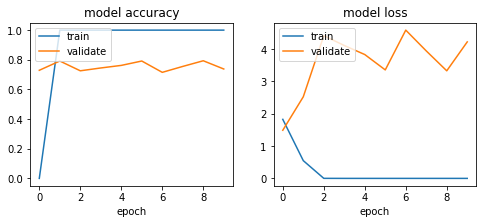

In [7]:
if(RUN_TRAINING):
    logger.info('Training info')
    cnn.show_training_info_keras(history)

### Confusion matrix

2017-06-03 18:47:02,496 INFO Evaluating model performance (552 samples)...
2017-06-03 18:47:02,499 INFO starting new flow...
2017-06-03 18:47:04,259 INFO Accuracy: 0.638888886819 - Loss: 5.820423762
2017-06-03 18:47:04,261 INFO Predicting Y for detailed analysis...
/notebooks/datascience-snippets/kaggle-sea-lion/modules/cnn.py:59: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(self.y_ds==None):
2017-06-03 18:47:06,296 INFO Accuracy: 0.614130434783
2017-06-03 18:47:06,300 INFO Number of test samples: 552
2017-06-03 18:47:06,303 INFO Kappa score: 0.0 (-1 bad; 0 just luck; 1 great)
/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall a

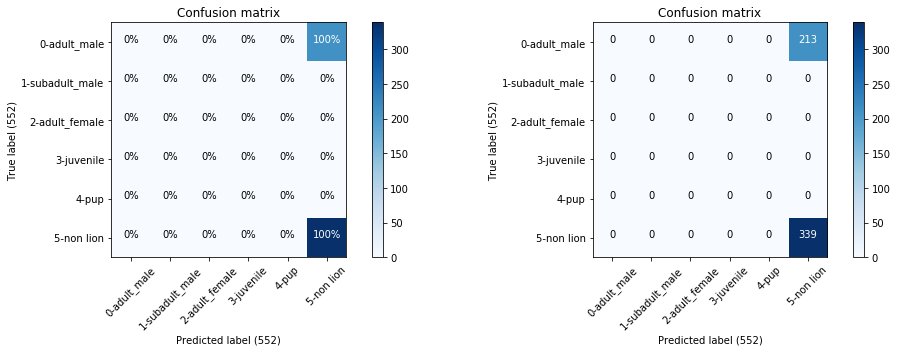

In [8]:
cnn.evaluate_dataset_keras(test_balance_generator.flow(), 
                       test_balance_generator.nr_batches, 
                       test_balance_generator.size, 
                       model, 
                       class_labels=lions.CLASS_LABELS)

2017-06-03 18:47:06,950 INFO > [started] generator dump...
2017-06-03 18:47:06,954 INFO starting new flow...


96/50

2017-06-03 18:47:06,977 INFO > [done]    generator dump (26.186 ms)
2017-06-03 18:47:07,152 INFO showing 50 images
2017-06-03 18:47:07,155 INFO > [started] generating image patches. rows=5; cols=12...


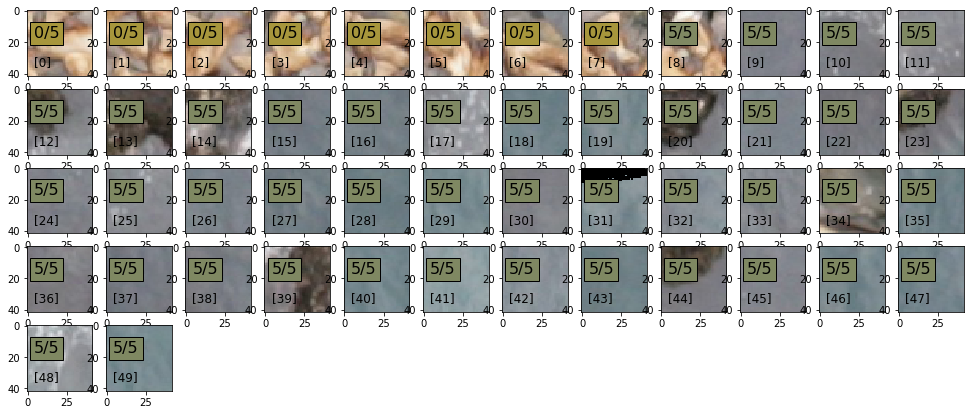

2017-06-03 18:47:11,396 INFO > [done]    generating image patches. rows=5; cols=12 (4241.096 ms)


In [9]:
a = test_balance_generator.flow()
cnn.show_predictions(a, 50, model)